# STAT 542 - Statistical Learning

# Homework 4 - Manan Mehta (mananm2)

## Due: 09/21/2020

## About HW4

This HW contains two major parts. In the first part, we will try to understand the properties of Ridge regression under a case where variables are highly correlated. In the first part, we perform an one-variable Lasso problem using the formula developed in the lecture. This one-variable Lasso code will then be used in HW5 to solve the solution of Lasso in a coordinate descent algorithm. Furthermore, the intercept and scaling issues need to be taking care of in a practical situation.

In [1]:
#Import all necessary packages
import numpy as np
import pandas as pd
import random
import datetime as dt
from scipy.stats import norm
from scipy.stats import uniform

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

## Question 1 (40 Points) Correrlated Variables in Ridge

For this question, we will use the same [Bitcoin data](https://teazrq.github.io/stat542/data/bitcoin.csv) we already constructed in HW3. Use the same training and testing data construction. You may have already noticed that if a linear model is used to perform that task, some parameters cannot be properly estimated, for example, the `n_transactions_total` parameter is only estimated on day 1, while for day 2 and 3, their parameter estimates are `NA` because they are both highly linearly dependent on day 1. Co-linearity is a severe problem of linear regression but Ridge regression can be used to solve that problem. 

### (20 Points) A Simulation Study

For this sub-question you must **write your own code** without using loading any additional package, but you can still use the `lm()` function from the base package. Construct your data in the following way

$$ Y = X_1 \times 0.7 + X_2 \times 0.8 + X_3 \times 0.9 + \epsilon $$
where $X_1$ and $\epsilon$ are generated independently from standard normal distribution, and the other two covariates are simply copies of $X_1$, meaning that $X_2 = X_3 = X_1$. Generate 100 samples from this model, make sure that you save a random seed. You should write down your own code to implement the ridge regression, and **no intercept is needed**. Answer the following questions before you actually fit the models:

  * What will happen (regarding the parameter estimates) when you fit a linear regression using data from this model? And why?
  * Will Ridge regression be able to address this problem? Will the parameters of the three variables be different or the same?
  * Using the singular value decomposition (SVD) and shrinkage understanding we developed during the lecture to explain why you would expect such results from the ridge regression. 
  
Now, use your generated data to confirm your statements. You do no need to tune the penalty term $\lambda$, just fix it at any nonzero value. Display sufficient information to support your statements, this includes the eigen-values and the rotation matrix $\mathbf{V}$ from the SVD of $X$. 

After preforming the above, modify your data by multiplying your $X_1$ by 2. Then use your code to fit the ridge regression again. What changes do you observe? Are the fitted value $\hat y$ changing? 

**Solution**

* If we fit a linear regression using data from this model, the regression will basically fit the model for X1 only and give 'NA' as the parameter estimates for X2 and X3. This is because the correlation between each variable is 1, so the covariance matrix is singular. In theory, the parameter estimates cannot be calculated using $ (X^TX)^{-1}X^Ty$ as the matrix $ (X^TX)$ is not invertible. R/Python handles this by ignoring the correlated covariates and only computing w.r.t. X1.

* Yes, Ridge Regression will address this issue as it basically solves the optimization with an added $L_2$ penalty. This "perturbs" the singular matrix $ (X^TX)^{-1}X^Ty$ in linear regression to $ (X^TX + \lambda I)^{-1}X^Ty $, which can be inverted. The parameters of the three variables will be the same as the covariates are exactly alike.

* We know that ridge regression 'shrinks' $\hat\beta ^{OLS}$ from the linear regression by a factor of $\frac{d_{jj}^2}{d_{jj}^2 + \lambda }$ where $d_{jj}$ is the $j^{th}$ singular value in the SVD $X = UDV^T$. For the purpose of this problem, we divide the coefficient of $X_1$ obtained from the linear regression into three equal parts, and assign one part each to $X_1$, $X_2$, and $X_3$. Thus $ Y \sim 3\beta X_1 $ is decomposed to $ Y \sim \beta X_1 + \beta X_2 + \beta X_3 $ which, without loss of generality, is the same model for our problem. Thus, after ridge regression, our coefficients should shrink to $\frac{d_{jj}^2}{d_{jj}^2 + \lambda } \beta$, which we will verify for diferent values of $\lambda$.

In [2]:
X1 = norm.rvs(size = 100 , random_state = 1)
X2, X3 = X1, X1
X = np.append(np.append(X1.reshape(100,1) , X2.reshape(100,1), axis = 1) , X3.reshape(100,1) , axis = 1)
epsilon = norm.rvs(size = 100, random_state = 2)
Y = X.dot([0.7, 0.8, 0.9]) + epsilon

**Fit a linear regression:**

(Note that Python automatically reassigns the coefficients to each variable, while R gives an output of [3 x 0.77 , NA, NA]. The underlying concept is the same and is understood.)

In [3]:
reg = LinearRegression(fit_intercept = False)
reg.fit(X, Y)
print("The coefficients for linear regression are " + str(np.round(reg.coef_ , 2)))

The coefficients for linear regression are [0.77 0.77 0.77]


**Fit a ridge regression for $\lambda$ = 5:**

In [4]:
def ridgeRegression(X, y, alpha = 1.0):
    '''
    Function to fit a ridge regression on the input data X,y 
    using alpha as the penalty coefficient
    
    Returns parameters for the ridge regression
    '''
    return np.linalg.inv(X.T.dot(X) + alpha*np.eye(X.shape[1])).dot(X.T.dot(y))

beta_ridge = ridgeRegression(X, Y, 5)
print("The coefficients for ridge regression are " + str(np.round(beta_ridge,2)))

The coefficients for ridge regression are [0.75 0.75 0.75]


As expected, the coefficients for ridge regression are the same. The values have also shrinked from 0.77 for OLS to 0.75

**Shrinkage**:

First perform SVD on the covariate matrix:

In [5]:
U , D , V = np.linalg.svd(X)

We then look at the eigenvalues of the covariance matrix $X^TX$ and see that they are identical to $D_{ii}^2$ from the singular values.

In [6]:
print("The eigenvalues of the covariance matrix are: " + str(np.round(np.linalg.eig(X.T.dot(X))[0] , 2)) )
print("The dii squared values are: " + str(np.round( D**2 , 2)))

The eigenvalues of the covariance matrix are: [236.15  -0.     0.  ]
The dii squared values are: [236.15   0.     0.  ]


Now, check the shrinkage ratio $\frac{d_{jj}^2}{d_{jj}^2 + \lambda }$ for $\lambda$ = 5:

In [7]:
dii = D[0]
print("The shrinkage ratio is :" + str(np.round(dii**2 / (dii**2 + 5) , 4)))
print("The calculated shrinkage ratio is :" + str(np.round(beta_ridge[0]/reg.coef_[0] , 4)))

The shrinkage ratio is :0.9793
The calculated shrinkage ratio is :0.9793


We see that the two shrinkages are identical. Using the same code, we can also show that for $\lambda$ = 236.15, the ridge regression coefficients are exactly halved from the OLS values. Hence, our calculation is consistent for all $\lambda$s.

**Data Modification**:

Now multiply $X_1$ by 2, keeping $X_2$ and $X_3$ the same.

In [8]:
X = np.append(np.append(2*X1.reshape(100,1) , X2.reshape(100,1), axis = 1) , X3.reshape(100,1) , axis = 1)
epsilon = norm.rvs(size = 100, random_state = 2)

beta_ridge_new = ridgeRegression(X, Y, 5)
print("The coefficients for ridge regression are " + str(np.round(beta_ridge_new,2)))

The coefficients for ridge regression are [0.76 0.38 0.38]


When we multiply $X1$ by 2, the coefficients of the other two variables are halved from before. We also note that the fitted $\hat{y}$ values do not change.

### (20 Points) Bitcoin Price Prediction Revisited

For this question, take the same training and testing split from the Bitcoin data, and fit a ridge regression. You can use any existing package to perform this.

  * State what criteria is used to select the best $\lambda$. 
  * State what values of $\lambda$ are considered and report your best lambda value.
  * Compare your model fitting results with the linear model in terms of their performances on the testing data. 

In [9]:
#First do the same preprocessing as done for the LR case
#Scale the data, remove outliers, split into train and test
#Refer to the notebook from HW3 for details.

#Import Data
csv_df = pd.read_csv('bitcoin.csv', usecols = range(1,24)).fillna(method = 'ffill', axis = 0)
#Data from 3 days used to predict 7th day
n_days, pred_day = 3 , 7

#Scale the data
ss = StandardScaler()
scaled_csv_df = pd.DataFrame(ss.fit_transform(csv_df.values) , columns = csv_df.columns)

#Remove outliers
outlier_idx = np.where(scaled_csv_df > 10)[0]
csv_df.drop(outlier_idx , inplace = True)
scaled_csv_df.drop(outlier_idx , inplace = True)

#Convert the data into analysis format
df = pd.DataFrame()
for i in range(len(csv_df.columns)):
    for j in range(n_days):
        df[i*n_days + j] = np.array(scaled_csv_df.iloc[j:-(pred_day-1)+j , i])

df.columns = [col+str(i) for col in csv_df.columns for i in range(1,n_days+1)]
df.insert(0, 'output', np.array(scaled_csv_df['btc_market_price'][(pred_day - 1):]) )
dates = np.array(pd.to_datetime(pd.read_csv('bitcoin.csv')['Date'].drop(outlier_idx))[(pred_day - 1):])
df.insert(0, 'output date', dates)

#Train-Test Split
traindf, testdf = df[df['output date'] < '2017-01-01'] , df[df['output date'] >= '2017-01-01']
X_train, y_train = traindf.iloc[:,2:].values , traindf.iloc[:,1].values
X_test, y_test = testdf.iloc[:,2:].values , testdf.iloc[:,1].values

The best value of lambda is: 0.0154


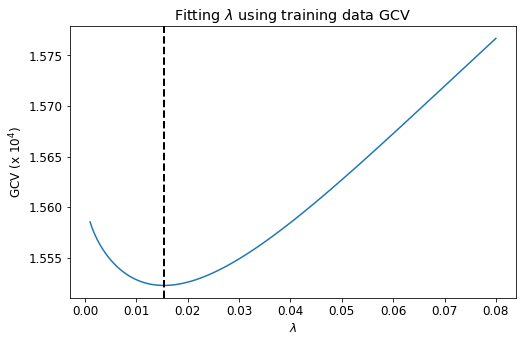

In [10]:
#We use the RidgeCV package from scikit-learn to fit lambda
#Search for lambda in 1000 values from 1e-03 to 8e-02
lambda_range = np.linspace(1e-03, 8e-02, 1000)

regressor = RidgeCV(alphas = lambda_range , fit_intercept = False, store_cv_values = True)
regressor.fit(X_train, y_train)
print("The best value of lambda is: {:.4f}".format(regressor.alpha_))

plt.figure(figsize = (8,5))
plt.plot(lambda_range , 1e04*np.mean(regressor.cv_values_ , axis = 0))
plt.axvline(x = regressor.alpha_ , lw = 2, ls = '--', color = 'black')
plt.ylabel('GCV (x $10^4 $)')
plt.xlabel('$ \lambda $')
plt.title('Fitting $\lambda$ using training data GCV')
plt.show()

In [11]:
#Test Error Comparison
y_predicted = regressor.predict(X_test)
MSE_Ridge = sum((y_predicted - y_test)**2)/len(y_test)

#For Linear Regression
MSE_LR = sum((LinearRegression().fit(X_train, y_train).predict(X_test) - y_test)**2)/len(y_test)

print("MSE for Ridge Regression: {:.4f}".format(MSE_Ridge))
print("MSE for Linear Regression: {:.4f}".format(MSE_LR))

MSE for Ridge Regression: 0.1432
MSE for Linear Regression: 0.1996


**Results**:

* We use Generalized Cross-Validation (GCV) criterion to fit $\lambda$

* The range for $\lambda$ considered is 1e-03 to 8e-02. The best GCV is obtained at $\lambda$ = 0.0154. (Note that this value may be prone to data pre-processing where we have standardized the covariates)

* We see that the Ridge model performs better than Linear Regression on the testing data

## Question 2 (60 Points) One Variable Lasso

Based on our development in the lecture, fitting a one variable Lasso is simply a soft-thresholding problem. Use the following code the generate a normalized data (if you use python, then do `import random` and call `random.seed(1)`)

Please be aware that instead of $\mathbf{X}^T \mathbf{X} = \mathbf{I}$ in the lecture note, we have $\mathbf{X}^T \mathbf{X} = n \mathbf{I}$. However, the derivation in page 33, 34 and 35 from the lecture notes remains largely unchanged except some scaling issues. We will derive a new result using the following objective function for this question:

$$\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

In [12]:
import random
random.seed(60)

X = np.array([random.gauss(0,1) for i in range(100)])
epsilon = np.array([random.gauss(0,1) for i in range(100)])
X = X / np.sqrt(sum(X**2)/100)

Y = X + epsilon

### (30 Points) The Soft-Thresholding Function

Consider a model **without intercept**. Perform the rest:

  * Re-derive the ${\hat \beta}^{\text Lasso}$ formula in page 34 and 35 based on this one variable Lasso problem with $\mathbf{X}^T \mathbf{X} = n\mathbf{I}$. What is the difference between this and the original one? 
  * After you obtaining the soft-thresholding solution similar to page 35, write a function in the form of `soft_th <- function(b, lambda)` to calculate it, where `b` is the OLS estimator, and $\lambda$ is the penalty level.
  * Apply this function to your data and obtain the Lasso solution. Report your results. Try a few different $\lambda$ values to see how that would alter the solution. You do not need to tune it.

**Solution**

Our objective function to be minimized is:

$$\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

$$ = \arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\hat\beta^{OLS} + \mathbf{X}\hat\beta^{OLS} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

On expanding $ \lVert \mathbf{y} - \mathbf{X}\hat\beta^{OLS} + \mathbf{X}\hat\beta^{OLS} - \mathbf{X}\beta \rVert^2 $ we see that the cross term is zero and $ \lVert \mathbf{y} - \mathbf{X}\hat\beta^{OLS} \rVert^2 $ does not depend on $\beta$. Thus:

$$ \hat\beta^{lasso} =  \arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{X}\hat\beta^{OLS} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

$$ = \arg\min_{\beta} \frac{1}{2n}  (\hat\beta^{OLS} - \beta)^T \mathbf{X}^T \mathbf{X} (\hat\beta^{OLS} - \beta) + \lambda \lVert \beta \rVert_1 $$

$$ = \arg\min_{\beta} \frac{1}{2}  \sum_{j = 1}^{p}(\hat\beta_j^{OLS} - \beta_j)^2 + \lambda \lVert \beta \rVert_1 $$

Following the derivation from class, the solution simply becomes:

$$ \hat\beta_j^{lasso} = sign(\hat\beta_j^{OLS}) (|\hat\beta_j^{OLS}| - \lambda)_+ $$

The difference between this and the original derivation is that the $\frac{\lambda}{2}$ term in the original derivation is now replaced by $ \lambda $

In [13]:
def soft_th(b , lamda = 1):
    '''
    Function to calculate the parameter for Lasso Regression
    given the OLS parameter
    Inputs:
    b - OLS estimator
    lamda - penalty level
    
    Outputs:
    b_lasso - Estimator for lasso regression
    
    '''
    if b > lamda:
        return b - lamda
    elif b < (-lamda):
        return b + lamda
    elif abs(b) <= lamda:
        return 0
    else:
        print("Error!")
        return 1e5

Results from the Model:

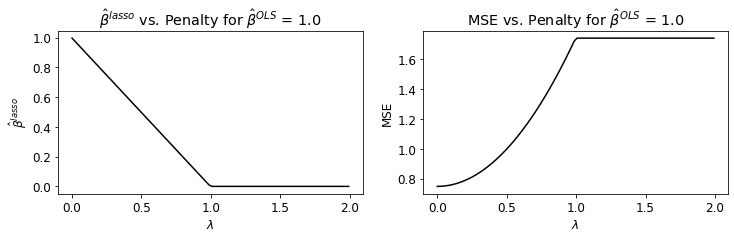

In [14]:
#Since we have only one variable Lasso, we can summarize results in a plot as follows:
beta_ols = 1/(X.T.dot(X)) * X.T.dot(Y)
lamda = np.linspace(0,abs(2*beta_ols),100)
beta_lasso = []
mse_lasso = []
for l in lamda:
    bl = soft_th(beta_ols , l)
    beta_lasso.append(bl)
    MSE = sum((X*bl - Y)**2)/len(Y)
    mse_lasso.append(MSE)

fig, axarr = plt.subplots(1,2,figsize = (12,3))
ax1, ax2 = axarr[0], axarr[1]

ax1.plot(lamda , beta_lasso, color = 'black')
ax1.set_title(r'$\hat\beta^{lasso}$ vs. Penalty for $\hat\beta^{OLS}$ = '+str(np.round(beta_ols,2)))
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$\hat\beta^{lasso} $')

ax2.plot(lamda , mse_lasso, color = 'black')
ax2.set_title(r'MSE vs. Penalty for $\hat\beta^{OLS}$ = '+str(np.round(beta_ols,2)))
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'MSE')


plt.show()

### (30 Points) The Intercept, Centering and Scaling Issues

Re-generate your data based on the following code:

In [15]:
random.seed(1)

X = np.array([random.gauss(1,2) for i in range(100)])
epsilon = np.array([random.gauss(0,1) for i in range(100)])

Y = 1 + X + epsilon

For this question, we will use a technique to deal with the center and scale of $X$ based on the intuition: 

$$
\begin{align}
\frac{Y - \bar{Y}}{\text{sd}_y} =&~ \sum_{j=1}^p \frac{X_j - \bar{X}_j}{\text{sd}_j} \gamma_j \\
Y =&~ \underbrace{\bar{Y} - \sum_{j=1}^p \bar{X}_j \frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_0} + \sum_{j=1}^p X_j \underbrace{\frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_j},
\end{align}
$$

A common practice when dealing with the intercept and scaling is to perform the following:

  * Center and scale both $\mathbf{X}$ (column-wise) and $\mathbf{y}$ and denote the processed data as $\frac{Y - \bar{Y}}{\text{sd}_y}$ and $\frac{X_j - \bar{X}_j}{\text{sd}_j}$ in the above formula.
  * Fit a linear regression (or Lasso) using the processed data based on the no-intercept model, and obtain the parameter estimates $\gamma_j$. In our case, there is only one $j$, i.e. $p=1$. 
  * Recover the original parameters $\beta_0$ and $\beta_j$'s. 
  
Understand and implement this procedure to our one-variable Lasso problem and obtain the Lasso solution on the original scale. You must write your own code and use the `soft_th()` function previously defined. For the choice of $\lambda$, use a value that does not give you a trivial solution. A trivial solution is $\beta^{Lasso}=0$ or $\beta^{OLS}$.

In [17]:
X_bar , sd_x = np.mean(X) , np.std(X)
Y_bar , sd_y = np.mean(Y) , np.std(Y)

X_centered = (X - X_bar) / sd_x
Y_centered = (Y - Y_bar) / sd_y

beta_ols = 1/(X_centered.T.dot(X_centered)) * X_centered.T.dot(Y_centered)
lamda = 0.05
beta_lasso = soft_th(beta_ols , lamda)
print("The OLS parameter for the centered data:{:.2f}".format(beta_ols))
print("The Lasso parameter (lambda = {:.2f}) for the centered data:{:.2f}".format(lamda,beta_lasso))

#Now recover the original parameters
beta_0 = Y_bar - X_bar*(sd_y / sd_x)*beta_lasso
beta_1 = (sd_y / sd_x)*beta_lasso
print("The (recovered) original parameters are: {:.2f} and {:.2f}".format(beta_0, beta_1))

The OLS parameter for the centered data:0.88
The Lasso parameter (lambda = 0.05) for the centered data:0.83
The (recovered) original parameters are: 1.26 and 0.90
